In [1]:
#Run from server

import os
os.environ["CUDA_VISIBLE_DEVICES"]="k,l"

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]

'k,l'

In [2]:
#Run from google colab

!pip install SimpleITK

from google.colab import drive
drive.mount('/content/gdrive')


     |████████████████████████████████| 47.4MB 88kB/s 
Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/MyDrive/2 TUM/Project/Internships/notebooks

/content/gdrive/MyDrive/2 TUM/Project/Internships/notebooks


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
import random

In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [5]:
def myshow(img):
    nda = sitk.GetArrayViewFromImage(img)
    plt.imshow(nda)

In [6]:
img_t1 = sitk.ReadImage(os.path.join("..", "data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_t1.nii.gz"))
img_t1ce = sitk.ReadImage(os.path.join("..", "data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_t1ce.nii.gz"))
img_t2 = sitk.ReadImage(os.path.join("..", "data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_t2.nii.gz"))
img_flair = sitk.ReadImage(os.path.join("..", "data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz"))
img_seg = sitk.ReadImage(os.path.join("..", "data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_seg.nii.gz"))

"""
img_t1 = sitk.Cast(img_t1,sitk.sitkFloat32) #to ceonvert png to sitk
img_t1ce = sitk.Cast(img_t1ce,sitk.sitkFloat32) #to ceonvert png to sitk
img_t2 = sitk.Cast(img,sitk_t2.sitkFloat32) #to ceonvert png to sitk
img_flair = sitk.Cast(img_flair,sitk.sitkFloat32) #to ceonvert png to sitk
img_seg = sitk.Cast(img_seg,sitk.sitkFloat32) #to ceonvert png to sitk

print(img.GetSize())
print(img.GetOrigin()) # the top left corner usually
print(img.GetSpacing()) #physical size of each pixel
print(img.GetDirection()) #3D matrix
print(img.GetNumberOfComponentsPerPixel()) #number of channels in one pixel
"""

width = img_t1.GetWidth()
height = img_t1.GetHeight()
depth = img_t1.GetDepth()

nda_t1 = sitk.GetArrayViewFromImage(img_t1)
nda_t1ce = sitk.GetArrayViewFromImage(img_t1ce)
nda_t2 = sitk.GetArrayViewFromImage(img_t2)
nda_flair = sitk.GetArrayViewFromImage(img_flair)
nda_seg = sitk.GetArrayViewFromImage(img_seg)

(-0.5, 239.5, 239.5, -0.5)

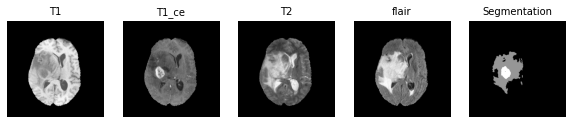

In [7]:
npa_zslice_t1 = sitk.GetArrayViewFromImage(img_t1)[int(depth/2),:,:]
npa_zslice_t1ce = sitk.GetArrayViewFromImage(img_t1ce)[int(depth/2),:,:]
npa_zslice_t2 = sitk.GetArrayViewFromImage(img_t2)[int(depth/2),:,:]
npa_zslice_flair = sitk.GetArrayViewFromImage(img_flair)[int(depth/2),:,:]
npa_zslice_seg = sitk.GetArrayViewFromImage(img_seg)[int(depth/2),:,:]

fig = plt.figure(figsize=(10,3))

fig.add_subplot(1,5,1)
plt.imshow(npa_zslice_t1, cmap=plt.cm.Greys_r)
plt.title('T1', fontsize=10)
plt.axis('off')

fig.add_subplot(1,5,2)
plt.imshow(npa_zslice_t1ce, cmap=plt.cm.Greys_r)
plt.title('T1_ce', fontsize=10)
plt.axis('off')

fig.add_subplot(1,5,3)
plt.imshow(npa_zslice_t2, cmap=plt.cm.Greys_r)
plt.title('T2', fontsize=10)
plt.axis('off')

fig.add_subplot(1,5,4)
plt.imshow(npa_zslice_flair, cmap=plt.cm.Greys_r)
plt.title('flair', fontsize=10)
plt.axis('off')

fig.add_subplot(1,5,5)
plt.imshow(npa_zslice_seg, cmap=plt.cm.Greys_r)
plt.title('Segmentation', fontsize=10)
plt.axis('off')

In [8]:
ImgDir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData")
features_path = list()
labels_path = list()
count = 0
limit = 100

for folder in os.listdir(ImgDir):
  count +=1
  if 'Training' in folder and count<limit:
        new_dir = os.path.join(ImgDir,folder)
        data = os.listdir(new_dir)
        for files in data:
            if 'flair' in files:
                features_path.append(os.path.join(new_dir, files))
            if 'seg' in files:
                labels_path.append(os.path.join(new_dir, files))

print(len(features_path))
print(len(labels_path))

X=features_path
Y=labels_path

99
99


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=1)

In [10]:
def keras_generator_train_val_test(batch_size, choice="train"):

    if choice == "train":
        X = X_train
        Y = y_train
    elif choice == "val":
        X = X_val
        y = y_val
    else:
        print("Invalid Option")
        return False
    
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            
            rand = random.choice(range(len(X)))

            x_path = X[rand]
            y_path = Y[rand]

            x = sitk.GetArrayViewFromImage(sitk.ReadImage(x_path))
            y = sitk.GetArrayViewFromImage(sitk.ReadImage(y_path))
            
            x = np.moveaxis(x, [0, 1, 2], [-1, -2, -3])
            y = np.moveaxis(y, [0, 1, 2], [-1, -2, -3])

            x = np.resize(x,(240,240,128,1))
            y = np.resize(y,(240,240,128,1))

            x_batch.append(x)
            y_batch.append(y)

        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        yield x_batch, y_batch

for x, y in keras_generator_train_val_test(10, choice="train"):
    print(x.shape, y.shape)
    break

(10, 240, 240, 128, 1) (10, 240, 240, 128, 1)


In [15]:
# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

import math
#import keras
import datetime
import tensorflow.python.keras

batch_size = 1
class BRATSSequence(tensorflow.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = X, Y
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        x_batch = []
        y_batch = []

        for i in range(batch_size):
            
            rand = random.choice(range(len(X)))

            x_path = X[rand]
            y_path = Y[rand]

            x = sitk.GetArrayViewFromImage(sitk.ReadImage(x_path)) / 255.
            y = sitk.GetArrayViewFromImage(sitk.ReadImage(y_path)) / 255.
            
            x = np.moveaxis(x, [0, 1, 2], [-1, -2, -3])
            y = np.moveaxis(y, [0, 1, 2], [-1, -2, -3])

            x = np.resize(x,(240,240,128,1))
            y = np.resize(y,(240,240,128,1))

            x_batch.append(x)
            y_batch.append(y)

        x_batch = np.array(x_batch)
        y_batch = np.array(y_batch)

        return x_batch, y_batch

    def on_epoch_end(self, epoch, logs=None):
        
        print("epoch finished")

sequence = BRATSSequence(X, Y, batch_size = 1)

In [16]:
sequence

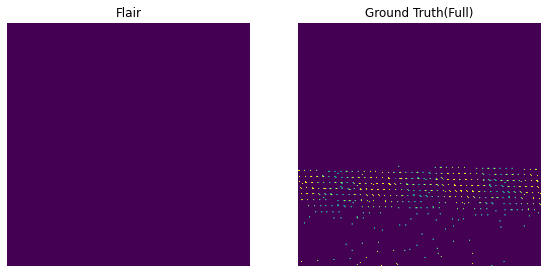

In [17]:
plt.figure(figsize=(20,10))

plt.subplot(241)
plt.title('Flair')
plt.axis('off')
plt.imshow(x[9, :, :, 100,0])
plt.subplot(242)
plt.title('Ground Truth(Full)')
plt.axis('off')
plt.imshow(y[9, :, :, 100,0])

In [23]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D, SpatialDropout3D
from tensorflow.python.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.python.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.regularizers import l2
#from tensorflow.python.keras.utils import plot_model

In [24]:
img_depth=128
img_rows=240
img_cols=240

smooth = 0.005 

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    

def get_unet():
    inputs = Input((img_rows, img_cols, img_depth,1))
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = SpatialDropout3D(0.5)(conv1)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = SpatialDropout3D(0.5)(conv2)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = SpatialDropout3D(0.5)(conv3)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = SpatialDropout3D(0.5)(conv4)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)

    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = SpatialDropout3D(0.5)(conv5)
    conv5 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), conv4], axis=4)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    #conv6 = SpatialDropout3D(0.5)(conv6)
    conv6 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), conv3], axis=4)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    #conv7 = SpatialDropout3D(0.5)(conv7)
    conv7 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    #conv8 = SpatialDropout3D(0.5)(conv8)
    conv8 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    #conv9 = SpatialDropout3D(0.5)(conv9)
    conv9 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)


    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    #plot_model(model, to_file='model.png')

    model.compile(optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.000000199), loss=dice_coef_loss, metrics=[dice_coef])

    return model


In [20]:
model2=get_unet()
model2.summary

NameError: name 'Conv3D' is not defined

In [ ]:
model2.fit(x=sequence, epochs=1, verbose=2, shuffle=True)

In [ ]:
import datetime

class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, epoch, logs={}):

        res_dir = "intermediate_results_black_background"

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

        print('Training: epoch {} begins at {}'.format(epoch, datetime.datetime.now().time()))

    def on_epoch_end(self, epoch, logs=None):
        res_dir = "intermediate_results_black_background/"
        print('Training: epoch {} ends at {}'.format(epoch, datetime.datetime.now().time()))
        
        for x_test, y_test in keras_generator_train_val_test(batch_size, choice="test"):
            break
        p = np.reshape(x_test[0], (1, 512, 512, 3))
        prediction = self.model.predict(p)

        x_img = f"{res_dir}{epoch}_X_input.jpg"
        y_img = f"{res_dir}{epoch}_Y_truth.jpg"
        predicted_img = f"{res_dir}{epoch}_Y_predicted.jpg"

        cv2.imwrite(x_img, x_test[0] * 255.)
        cv2.imwrite(y_img, y_test['seg'][0] * 255.)
        cv2.imwrite(predicted_img, prediction[0] * 255.)

In [ ]:
model_name = "..\\data\\Unet_black_background_47_epochs.h5"

batch_size = 2;

#modelcheckpoint = ModelCheckpoint(model_name,
                                  monitor='val_loss',
                                  mode='auto',
                                  verbose=1,
#                                  save_best_only=True)

lr_callback = ReduceLROnPlateau(min_lr=0.000001)

#callback_list = [modelcheckpoint, lr_callback, MyCustomCallback()]

history = model.fit_generator(
    keras_generator_train_val_test(batch_size, choice="train"),
    validation_data = keras_generator_train_val_test(batch_size, choice="val"),
    validation_steps = 100,
    steps_per_epoch=100,
    epochs=epochs,
    verbose=1, 
    shuffle=True
    #callbacks = callback_list,
)

In [ ]:

def keras_generator_train_val_test(batch_size, choice="train"):

    if choice == "train":
        X = X_train
        y = y_train
    elif choice == "val":
        X = X_val
        y = y_val
    else:
        print("Invalid Option")
        return False
        
    while True:
        x_batch = []
        y_batch = []

        for i in range(batch_size):
            
            x = sitk.ReadImage(X[i])
            x_np = sitk.GetArrayViewFromImage(x) / 255.
            y = sitk.ReadImage(y[i])
            y_np = sitk.GetArrayViewFromImage(y) / 255.
            
            x_batch.append(x_np)
            y_batch.append(y_np)

        
        x_batch = np.array(x_batch)
        # y_batch = np.array(y_batch)

        y_batch = {'seg': np.array(y_batch),
                #    'cls': np.array(classification_list)
                }

        yield x_batch, y_batch

for x, y in keras_generator_train_val_test(2, choice="train"):
    break

print(x.shape, y['seg'].shape)